In [2]:
from easydict import EasyDict
from datetime import datetime
import pandas as pd

import pyupbit
from fbprophet import Prophet

from modules import utils


In [ ]:
pd.options.display.float_format = '{:.5f}'.format

## 코인 정보 확인

In [2]:
krw_tickers = pyupbit.get_tickers("KRW")
print(krw_tickers)

['KRW-BTC', 'KRW-ETH', 'KRW-NEO', 'KRW-MTL', 'KRW-LTC', 'KRW-XRP', 'KRW-ETC', 'KRW-OMG', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM', 'KRW-QTUM', 'KRW-LSK', 'KRW-STEEM', 'KRW-XLM', 'KRW-ARDR', 'KRW-ARK', 'KRW-STORJ', 'KRW-GRS', 'KRW-REP', 'KRW-ADA', 'KRW-SBD', 'KRW-POWR', 'KRW-BTG', 'KRW-ICX', 'KRW-EOS', 'KRW-TRX', 'KRW-SC', 'KRW-ONT', 'KRW-ZIL', 'KRW-POLY', 'KRW-ZRX', 'KRW-LOOM', 'KRW-BCH', 'KRW-BAT', 'KRW-IOST', 'KRW-RFR', 'KRW-CVC', 'KRW-IQ', 'KRW-IOTA', 'KRW-MFT', 'KRW-ONG', 'KRW-GAS', 'KRW-UPP', 'KRW-ELF', 'KRW-KNC', 'KRW-BSV', 'KRW-THETA', 'KRW-QKC', 'KRW-BTT', 'KRW-MOC', 'KRW-ENJ', 'KRW-TFUEL', 'KRW-MANA', 'KRW-ANKR', 'KRW-AERGO', 'KRW-ATOM', 'KRW-TT', 'KRW-CRE', 'KRW-MBL', 'KRW-WAXP', 'KRW-HBAR', 'KRW-MED', 'KRW-MLK', 'KRW-STPT', 'KRW-ORBS', 'KRW-VET', 'KRW-CHZ', 'KRW-STMX', 'KRW-DKA', 'KRW-HIVE', 'KRW-KAVA', 'KRW-AHT', 'KRW-LINK', 'KRW-XTZ', 'KRW-BORA', 'KRW-JST', 'KRW-CRO', 'KRW-TON', 'KRW-SXP', 'KRW-HUNT', 'KRW-PLA', 'KRW-DOT', 'KRW-SRM', 'KRW-MVL', 'KRW-STRAX', 'KRW-AQT', 'KRW-GLM', 

In [35]:
df = pyupbit.get_ohlcv(config.dataset.ticker, 
                       config.dataset.interval, 
                       count=504, 
                       to=config.dataset.to, 
                       period=0)
# open : 시가, high : 고가, low : 저가, close : 종가, volume : 거래량

## 모델 검증

In [1]:
import time
import copy
from datetime import datetime, timedelta

from easydict import EasyDict
import numpy as np
import pandas as pd

import pyupbit
from fbprophet import Prophet
from modules import utils, upbitfunc, models, strategies, validation

In [2]:
config_name = 'config1'
config = utils.get_json(f'./config/{config_name}.json')
config = EasyDict(config)
config = utils.set_config_restrictions(config)

In [3]:
# 특정 날짜 사이의 모든 시간대로 date_list 구성
start_date = '20220215 09'
end_date = '20220301 09'

date_list = []
date = datetime.strptime(start_date, '%Y%m%d %H')
end_date = datetime.strptime(end_date, '%Y%m%d %H')
while date != end_date:
    date_list.append(date.strftime("%Y%m%d %H"))
    date += timedelta(hours=1)

In [4]:
# 매달 1일, 16일의 open_hour, open_hour+12시로 date_list 구성
date_list = []
month_list = list(range(1,13))
day_list = [1, 16]
hour_list = sorted([config.trade.open_hour, (config.trade.open_hour+12)%24])

for m in month_list:
    for d in day_list:
        for h in hour_list:
            date_list.append(f'{2021}{m:0>2}{d:0>2} {h:0>2}')

for m in [1,2,3]:
    for d in day_list:
        for h in hour_list:
            date_list.append(f'{2022}{m:0>2}{d:0>2} {h:0>2}')

In [8]:
model_validation_df, mae = validation.model_validation(config, date_list)

Validate Model with 60 data
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃  idx ┃             train date              ┃   predict date   ┃      y      ┃     yhat    ┃    time   ┃
┣━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃    0 ┃ 2020-12-24 02:00 ~ 2021-01-01 09:00 ┃ 2021-01-02 09:00 ┃  32295000.0 ┃  33122526.7 ┃  1.81 sec ┃
┃    1 ┃ 2020-12-24 14:00 ~ 2021-01-01 21:00 ┃ 2021-01-02 09:00 ┃  32295000.0 ┃  32608197.8 ┃  1.62 sec ┃
┃    2 ┃ 2021-01-08 02:00 ~ 2021-01-16 09:00 ┃ 2021-01-17 09:00 ┃  40070000.0 ┃  40073223.2 ┃  1.54 sec ┃
┃    3 ┃ 2021-01-08 14:00 ~ 2021-01-16 21:00 ┃ 2021-01-17 09:00 ┃  40070000.0 ┃  39376024.2 ┃  1.60 sec ┃
┃    4 ┃ 2021-01-24 02:00 ~ 2021-02-01 09:00 ┃ 2021-02-02 09:00 ┃  36618000.0 ┃  35142031.3 ┃  1.65 sec ┃
┃    5 ┃ 2021-01-24 14:00 ~ 2021-02-01 21:00 ┃ 2021-02-02 09:00 ┃  36618000.0 ┃  36301523.0 ┃  1.49 sec ┃
┃    6 ┃ 2021-02-0

In [9]:
model_validation_df

,start_train_date,end_train_date,predict_date,y,yhat,time
0,2020-12-24 02:00:00,2021-01-01 09:00:00,2021-01-02 09:00:00,32295000.0,3.312253e+07,1.812910
1,2020-12-24 14:00:00,2021-01-01 21:00:00,2021-01-02 09:00:00,32295000.0,3.260820e+07,1.623247
2,2021-01-08 02:00:00,2021-01-16 09:00:00,2021-01-17 09:00:00,40070000.0,4.007322e+07,1.539681
3,2021-01-08 14:00:00,2021-01-16 21:00:00,2021-01-17 09:00:00,40070000.0,3.937602e+07,1.596405
4,2021-01-24 02:00:00,2021-02-01 09:00:00,2021-02-02 09:00:00,36618000.0,3.514203e+07,1.645362
5,2021-01-24 14:00:00,2021-02-01 21:00:00,2021-02-02 09:00:00,36618000.0,3.630152e+07,1.487484
6,2021-02-08 02:00:00,2021-02-16 09:00:00,2021-02-17 09:00:00,54760000.0,5.249894e+07,1.676762
7,2021-02-08 14:00:00,2021-02-16 21:00:00,2021-02-17 09:00:00,54760000.0,5.389709e+07,1.456364
8,2021-02-21 02:00:00,2021-03-01 09:00:00,2021-03-02 09:00:00,56438000.0,4.997013e+07,1.551305
9,2021-02-21 14:00:00,2021-03-01 21:00:00,2021-03-02 09:00:00,56438000.0,5.206345e+07,1.588447


In [10]:
mae

1594453.2314682528

## 백테스팅

In [1]:
import time
import copy
from datetime import datetime, timedelta

from easydict import EasyDict
import numpy as np
import pandas as pd

import pyupbit
from fbprophet import Prophet
from modules import utils, upbitfunc, models, strategies, validation

In [11]:
config_name = 'config1'
config = utils.get_json(f'./config/{config_name}.json')
config = EasyDict(config)
config = utils.set_config_restrictions(config)

In [12]:
money = 1000000
start_date = f'20220201 {config.trade.open_hour:0>2}'
end_date = f'20220301 {config.trade.open_hour:0>2}'

In [13]:
# get target date list
date_list = []
date = datetime.strptime(start_date, '%Y%m%d %H')
end_date = datetime.strptime(end_date, '%Y%m%d %H')
while date != end_date:
    date_list.append(date.strftime("%Y%m%d %H"))
    date += timedelta(hours=1)

In [15]:
backtesting_df, stock_yield = validation.backtesting(config, money, date_list)

Back-Testing Model with 672 data
┏━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃  idx ┃     datetime     ┃ current price ┃ predict price ┃  sell ┃  buy  ┃   money  ┃    coin    ┃    time   ┃
┣━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃    0 ┃ 2022-02-01 09:00 ┃    47304000.0 ┃           0.0 ┃ False ┃ False ┃  1000000 ┃  0.0000000 ┃  0.21 sec ┃
┃    1 ┃ 2022-02-01 10:00 ┃    47152000.0 ┃           0.0 ┃ False ┃ False ┃  1000000 ┃  0.0000000 ┃  0.20 sec ┃
┃    2 ┃ 2022-02-01 11:00 ┃    47194000.0 ┃           0.0 ┃ False ┃ False ┃  1000000 ┃  0.0000000 ┃  0.21 sec ┃
┃    3 ┃ 2022-02-01 12:00 ┃    47427000.0 ┃           0.0 ┃ False ┃ False ┃  1000000 ┃  0.0000000 ┃  0.24 sec ┃
┃    4 ┃ 2022-02-01 13:00 ┃    47500000.0 ┃           0.0 ┃ False ┃ False ┃  1000000 ┃  0.0000000 ┃  0.57 sec ┃
┃    5 ┃ 2022-02-01 14:00 ┃    47403000.0 ┃           0.0 ┃ False ┃ Fal

In [17]:
backtesting_df

,datetime,current_price,predict_price,sell,buy,money,coin,time
0,2022-02-01 09:00:00,47304000.0,0,False,False,1000000,0,0.207606
1,2022-02-01 10:00:00,47152000.0,0,False,False,1000000,0,0.204515
2,2022-02-01 11:00:00,47194000.0,0,False,False,1000000,0,0.212131
3,2022-02-01 12:00:00,47427000.0,0,False,False,1000000,0,0.238078
4,2022-02-01 13:00:00,47500000.0,0,False,False,1000000,0,0.574944
...,...,...,...,...,...,...,...,...
667,2022-03-01 04:00:00,49982000.0,4.7626e+07,False,False,983317,0,1.686757
668,2022-03-01 05:00:00,50176000.0,4.7869e+07,False,False,983317,0,1.424304
669,2022-03-01 06:00:00,50869000.0,4.80696e+07,False,False,983317,0,1.474478
670,2022-03-01 07:00:00,50573000.0,4.84839e+07,False,False,983317,0,1.489255


In [16]:
stock_yield

-1.6682978410722527

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches

In [215]:
coin_y[buy_x]

array([47905000., 51093000., 52301000., 54214000., 54088000., 53472000.,
       48133000., 48379000.])

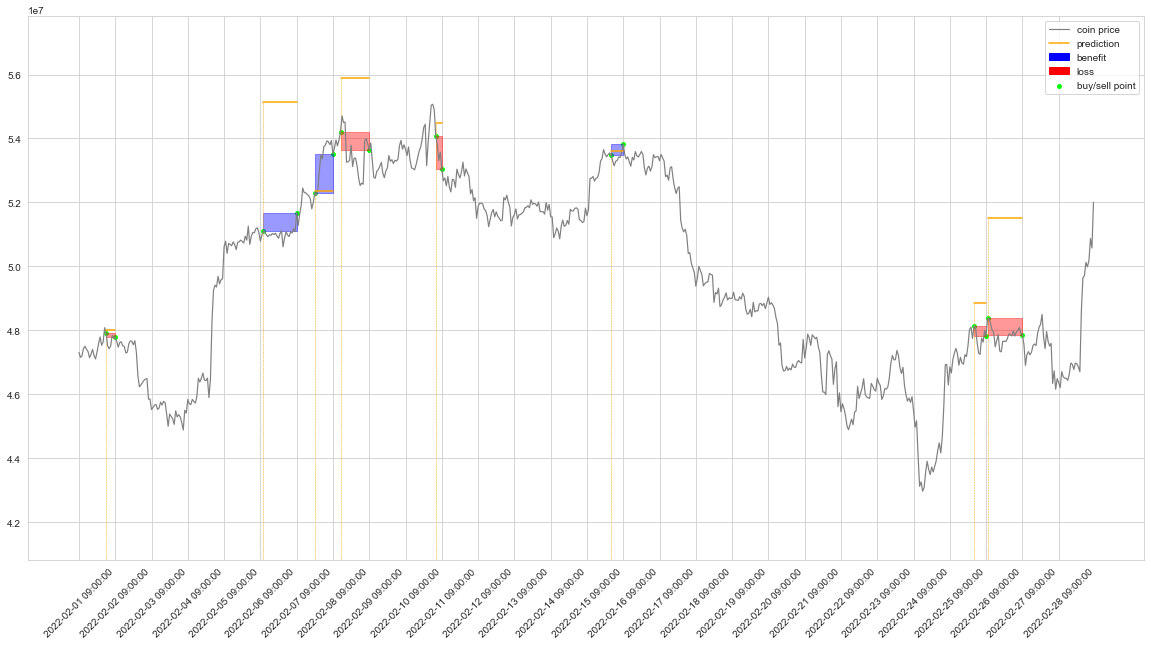

In [248]:
# plot setting
plt.figure(figsize = (20, 10))
sns.set_style('whitegrid')

# get data
coin_y = backtesting_df['current_price'].values

buy_df = backtesting_df[backtesting_df.buy==True]
buy_x = buy_df.index.values
sell_x = [(i+24)//24*24 for i in buy_df.index]
buy_yhat = buy_df['predict_price'].values

# plot data
plt.plot(coin_y, c = 'gray', label='coin price', linewidth=1.2)
plt.scatter(buy_x, coin_y[buy_x], c='lime', s=15, label='buy/sell point')
plt.scatter(sell_x, coin_y[sell_x], c='lime', s=15)
for idx in range(0, len(buy_x)):
 
    plt.plot([buy_x[idx], sell_x[idx]], [buy_yhat[idx]]*2, c='orange')
    
    plt.vlines(x = buy_x[idx], 
               ymin = min(coin_y)*0.95,
               ymax = buy_yhat[idx], 
               linestyle = '--',
               linewidth = 0.5,
               color = 'orange')
    
    rec_xs = [buy_x[idx], sell_x[idx]]
    rec_ys = [coin_y[buy_x[idx]], coin_y[sell_x[idx]]]
    if rec_ys[0] < rec_ys[1]:
        rec_color = 'blue'
    else:
        rec_ys[0], rec_ys[1] = rec_ys[1], rec_ys[0]
        rec_color = 'red'
    
    plt.gca().add_patch(patches.Rectangle((rec_xs[0], rec_ys[0]), 
                                           rec_xs[1]-rec_xs[0], 
                                           rec_ys[1]-rec_ys[0],
                                           alpha = 0.4,
                                           color = rec_color))

# legend
plt.plot([0,0], c='orange', label='prediction')
plt.gca().add_patch(patches.Rectangle((0, 0), 0, 0, color = 'blue', label = 'benefit'))
plt.gca().add_patch(patches.Rectangle((0, 0), 0, 0, color = 'red', label = 'loss'))
plt.legend()

# plot setting
plt.ylim(min(coin_y)*0.95, max(coin_y)*1.05)
plt.xticks(list(range(0, len(backtesting_df), 24)),
           labels = backtesting_df['datetime'][list(range(0, len(backtesting_df), 24))],
           rotation = 45)


plt.show()